In [2]:
import folium
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
from affine import Affine
from rasterio import features, warp
from rasterio.enums import Resampling
from rasterio.plot import show, show_hist
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, transform_bounds
from shapely.geometry import Point, Polygon, mapping, box, shape
from tqdm import tqdm

import geopandas as gpd
import mercantile
import pandas as pd
import rasterio
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from pyproj import Transformer
from rasterio.features import geometry_mask, rasterize
from rasterio.plot import show
from rasterio.transform import from_origin
from rastervision.core import Box
from rastervision.core.data import GeoJSONVectorSource, RasterSourceConfig, SemanticSegmentationLabelSourceConfig
from rastervision.core.data import GeoJSONVectorSourceConfig

In [2]:
# Create output directory if it doesn't exist
output_directory = '../data/1/'
os.makedirs(output_directory, exist_ok=True)

df = pd.read_csv('../data/0/worldcities.csv')
# List of Central American countries
iso2_codes = ['HT'] #, 'HT', 'SV', 'GT', 'HN', 'NI', 'PA', 'HT', 'JM', 'CU']

# Filter the DataFrame for Central American countries
df = df[df['iso2'].isin(iso2_codes)]
df = df[df['population'] > 20000]
df = df.head(1)
df = df.sort_values(by='population', ascending=False)
cities = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lng'], df['lat']))

# Function to create bounding box around each point based on population
def create_bbox_based_on_population(row):
    # Define the minimum and maximum bounding box sizes
    min_size = 2
    max_size = 2
    
    # Calculate the size of the bounding box based on population
    population = row['population']
    bbox_size = min_size + (max_size - min_size) * (population / cities['population'].max())
    
    # Convert distance from kilometers to degrees (approximate)
    distance_deg = bbox_size / 111.0
    lon, lat = row['geometry'].x, row['geometry'].y
    return box(lon - distance_deg, lat - distance_deg, lon + distance_deg, lat + distance_deg)

# Create bounding box around each point based on population
cities['bbox'] = cities.apply(create_bbox_based_on_population, axis=1)

city_polygons = cities['bbox'].unary_union
city_polygons = gpd.GeoDataFrame(geometry=[city_polygons], crs='EPSG:4326')

In [3]:
# Folium Map
m = folium.Map(location=[18.54134069348532, -72.33967147665213], zoom_start=10)
folium.GeoJson(city_polygons).add_to(m)
# folium.GeoJson(gdf).add_to(m)
m

In [3]:
# Rastervision Prep of Data
gdf = gpd.read_file("../data/1/UNITAC_data/SantoDomingo_PS.geojson")
xmin, ymin, xmax, ymax = gdf.total_bounds
resolution = 0.000005

# Calculate the width and height of the raster
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)
transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height)
raster_data = np.zeros((height, width), dtype=np.uint8)


for geom in gdf.geometry:
    raster_data = rasterize(
        [(geom, 1)],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=np.uint8,
    )

# Save the raster as a GeoTIFF
with rasterio.open(
    "../data/1/UNITAC_data/SantoDomingo_PS.tif",
    "w",
    driver="GTiff",
    height=raster_data.shape[0],
    width=raster_data.shape[1],
    count=1,
    dtype=raster_data.dtype,
    crs=gdf.crs,
    transform=transform,
) as dst:
    dst.write(raster_data, 1)


In [7]:
### Function to prepare data FOR RASTERVISION ###
def rasterize_gdf(gdf_path, resolution=0.000008983):
    # Read the GeoDataFrame
    gdf = gpd.read_parquet(gdf_path)
    # gdf = gdf.head(100)
    xmin, ymin, xmax, ymax = gdf.total_bounds
    print(xmin, ymin, xmax, ymax)

    # Calculate the width and height of the raster
    width = int((xmax - xmin) / resolution)
    height = int((ymax - ymin) / resolution)
    transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, width, height)
    raster_data = np.zeros((height, width), dtype=np.uint8)
    print(transform)

    # Rasterize the geometry
    for geom in gdf.geometry:
        raster_data = rasterize(
            [(geom, 1)],
            out_shape=(height, width),
            transform=transform,
            fill=0,
            all_touched=True,
            dtype=np.uint8,
        )

    # Prepare the raster file name
    raster_file_name = os.path.splitext(os.path.basename(gdf_path))[0] + '.tif'
    raster_file_path = os.path.join(os.path.dirname(gdf_path), raster_file_name)
    print(f"Prepped raster file name: {raster_file_name}")

    # Save the raster as a GeoTIFF
    with rasterio.open(
        raster_file_path,
        "w",
        driver="GTiff",
        height=raster_data.shape[0],
        width=raster_data.shape[1],
        count=1,
        dtype=raster_data.dtype,
        crs=gdf.crs,
        transform=transform,
    ) as dst:
        dst.write(raster_data, 1)

    print(f"Raster file saved at: {raster_file_path}")
    
rasterize_gdf("../data/0/overture/portauprince.parquet")

-72.4075011 18.4698972 -72.1820459 18.6911143
| 0.00, 0.00,-72.41|
| 0.00,-0.00, 18.69|
| 0.00, 0.00, 1.00|


In [6]:
# Donwload
gdf = gpd.read_file('../data/0/buildings_queried.geojson').to_crs(epsg=4326)
gdf = gpd.sjoin(gdf, city_polygons, how="inner", op='within') # Spatial join with the city polygons

gdf_utm = gdf.to_crs('EPSG:31970')
city_polygons_utm = city_polygons.to_crs('EPSG:31970')

resolution = 1 # meters
image_size = 2000 # pixels
window_size = 340

rastervision_prep(gdf_31970, city_polygons_utm, resolution, image_size, window_size, confidence=False)

In [7]:
### FUNCTIONS FOR CUSTOM RASTERISATION ###
def rasterize_with_window(gdf, aoi_polygon, resolution, image_size, output_folder, confidence=False, pngs=False, geotiffs=True):
    # Get the extent of the AOI polygon
    # aoi_bounds = aoi_polygon.bounds
    os.makedirs(output_folder, exist_ok=True)
    minx, miny, maxx, maxy = aoi_polygon.total_bounds
    
    # Determine the window size based on the resolution
    window_size = resolution * image_size
    
    # Determine the number of windows based on the window size
    num_windows_x = int(np.ceil((maxx - minx) / window_size))
    num_windows_y = int(np.ceil((maxy - miny) / window_size))
    
    for i in tqdm(range(num_windows_x)):
        for j in range(num_windows_y):
            # Calculate window bounds
            window_minx = minx + i * window_size
            window_miny = miny + j * window_size
            window_maxx = min(window_minx + window_size, maxx)
            window_maxy = min(window_miny + window_size, maxy)
            
            # Create the window polygon
            window_polygon = Polygon([(window_minx, window_miny), (window_maxx, window_miny),
                                      (window_maxx, window_maxy), (window_minx, window_maxy),
                                      (window_minx, window_miny)])
            
            # Check if any geometry in the AOI polygon intersects with the window polygon
            if not any(window_polygon.intersects(geom) for geom in aoi_polygon.geometry):
                continue
            
            # Create a windowed GeoDataFrame
            window_gdf = gdf.cx[window_minx:window_maxx, window_miny:window_maxy]
            
            # Skip empty windows
            if window_gdf.empty:
                continue

            #Create a list of geometry-confidence value pairs
            if confidence:
                shapes = [(geom, confidence) for geom, confidence in zip(window_gdf.geometry, window_gdf['confidence'])]
            else:
                shapes = [(geom, 1) for geom in window_gdf.geometry]
            
            # Create a blank raster
            raster_shape = (image_size, image_size)
            transform = from_origin(window_minx, window_maxy, window_size / raster_shape[0], window_size / raster_shape[1])
            rasterized = rasterize(shapes, out_shape=raster_shape, transform=transform, fill=0, 
                                   all_touched=True, default_value=np.nan, dtype=float)
            
            # Save PNGs
            if pngs:
                fig, ax = plt.subplots(1, figsize=(10, 10))
                show(rasterized, ax=ax)
                ax.axis('off')
                plt.savefig(f"{output_folder}/img_res{resolution}_{i}_{j}.png",
                            bbox_inches='tight', pad_inches = 0, dpi = image_size / 10)
                plt.close()
            
            # Save GEOTIFFs
            if geotiffs:
                with rasterio.MemoryFile() as memfile:
                    with memfile.open(driver='GTiff', height=rasterized.shape[0], width=rasterized.shape[1], count=1,
                                    dtype=str(rasterized.dtype), crs='EPSG:31970', transform=transform) as src:
                        src.write(rasterized, 1)

                        # Reproject the raster to 'EPSG:4326'
                        transform, width, height = calculate_default_transform(src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
                        with rasterio.open(f"{output_folder}/window_res{resolution}_{i}_{j}.tif", 'w', driver='GTiff',
                                        height=height, width=width, count=1, dtype=str(rasterized.dtype),
                                        crs='EPSG:4326', transform=transform) as dst:
                            reproject(
                                source=rasterio.band(src, 1),
                                destination=rasterio.band(dst, 1),
                                src_transform=src.transform,
                                src_crs=src.crs,
                                dst_transform=transform,
                                dst_crs='EPSG:4326',
                                resampling=Resampling.nearest)

In [15]:
# Donwload
# gdf = gpd.read_parquet('../data/0/overture/portauprince.parquet').to_crs(epsg=4326) # Read the Parquet file for country
gdf = gpd.read_file('../data/0/overture/portauprince.geojson').to_crs(epsg=4326)
gdf = gpd.sjoin(gdf, city_polygons, how="inner", op='within') # Spatial join with the city polygons

gdf_utm = gdf.to_crs('EPSG:31970')
city_polygons_utm = city_polygons.to_crs('EPSG:31970')

resolution = 0.5 # meters
image_size = 256 # pixels
output_directory = '../data/1/ov_custom/'

rasterize_with_window(gdf_utm, city_polygons_utm, resolution, image_size, output_directory, confidence=False, pngs=True, geotiffs=True)

100%|██████████| 34/34 [00:29<00:00,  1.16it/s]



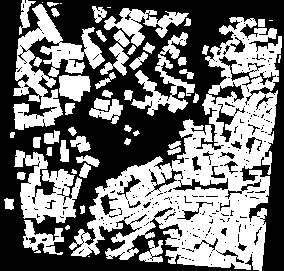

In [13]:
# Open the raster image
raster_path = '../data/1/ov_custom/window_res1_1_4.tif'
with rasterio.open(raster_path) as src:
    left, bottom, right, top = src.bounds
    left, bottom, right, top = transform_bounds(src.crs, 'EPSG:4326', left, bottom, right, top)

    # Create a map centered at the center of the raster
    m = folium.Map(location=[(top + bottom) / 2, (right + left) / 2], zoom_start=13)
    folium.raster_layers.ImageOverlay(
        image=src.read(1, out_shape=(src.height, src.width), resampling=Resampling.bilinear),
        bounds=[[bottom, left], [top, right]],
        opacity=0.6,
    ).add_to(m)
m

Number of bands: 1


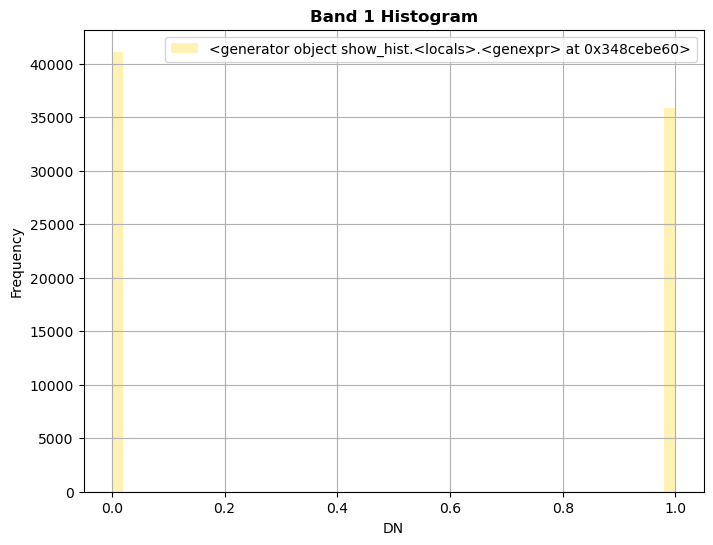

In [14]:
with rasterio.open(raster_path) as src:
    # Get the number of bands
    num_bands = src.count
    print("Number of bands:", num_bands)
        
    for band_idx in range(1, num_bands + 1):
        band = src.read(band_idx)
        plt.figure(figsize=(8, 6))
        show_hist(band, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title=f'Band {band_idx} Histogram')
        plt.show()